Starting eco-driving analysis on ts_1747221572.csv
Parsed data summary:
GPS data: 1792 records
Accelerometer data: 226183 records
Gyroscope data: 32236 records
Rotation vector data: 7326 records

DETAILED DATA INSPECTION

==================== GPS DATA ====================
Shape: (1792, 8) (rows, columns)
Columns: ['data_type', 'timestamp', 'latitude', 'longitude', 'altitude', 'speed', 'satellites', 'speed_kmh']

GPS missing values:
  data_type: 0
  timestamp: 0
  latitude: 0
  longitude: 0
  altitude: 0
  speed: 0
  satellites: 0
  speed_kmh: 0

GPS basic statistics:
       data_type     timestamp     latitude    longitude     altitude  \
count     1792.0  1.792000e+03  1792.000000  1792.000000  1792.000000   
mean         0.0  1.747222e+09    57.764149    12.001235    11.480915   
std          0.0  5.195074e+02     0.066970     0.012425    19.887072   
min          0.0  1.747222e+09    57.685970    11.980688    -7.600000   
25%          0.0  1.747222e+09    57.695534    11.987949     

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(



Feature importance for energy consumption:
  acceleration: 0.5849
  speed: 0.4139
  gradient: 0.0011
  turning_rate: 0.0001
  driver_cluster_1: 0.0000
  driver_cluster_0: 0.0000
  driver_cluster_2: 0.0000
Eco-driving analysis completed successfully

Visualization diagnostics:
Energy factor range: 0.0 - 2612735.032063338
Top 5 feature importance values:
  acceleration: 0.584866
  speed: 0.413873
  gradient: 0.001114
  turning_rate: 0.000087
  driver_cluster_1: 0.000036


C:\Users\xiach\AppData\Local\Temp\ipykernel_28348\2050843089.py:1465: RuntimeWarning: divide by zero encountered in log10
  plt.plot(range(len(sample)), np.log10(sample['energy_factor'].values), 'b-')


Saved main visualization to 'eco_driving_results.png'
Saved control strategies visualization to 'control_strategies.png'


d:\Anaconda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Saved driver behavior analysis visualization to 'driver_behavior_analysis.png'
Saved processed data to 'eco_driving_data.csv'
Saved cluster profiles to 'cluster_profiles.txt'
Saved control strategies to 'control_strategies.txt'


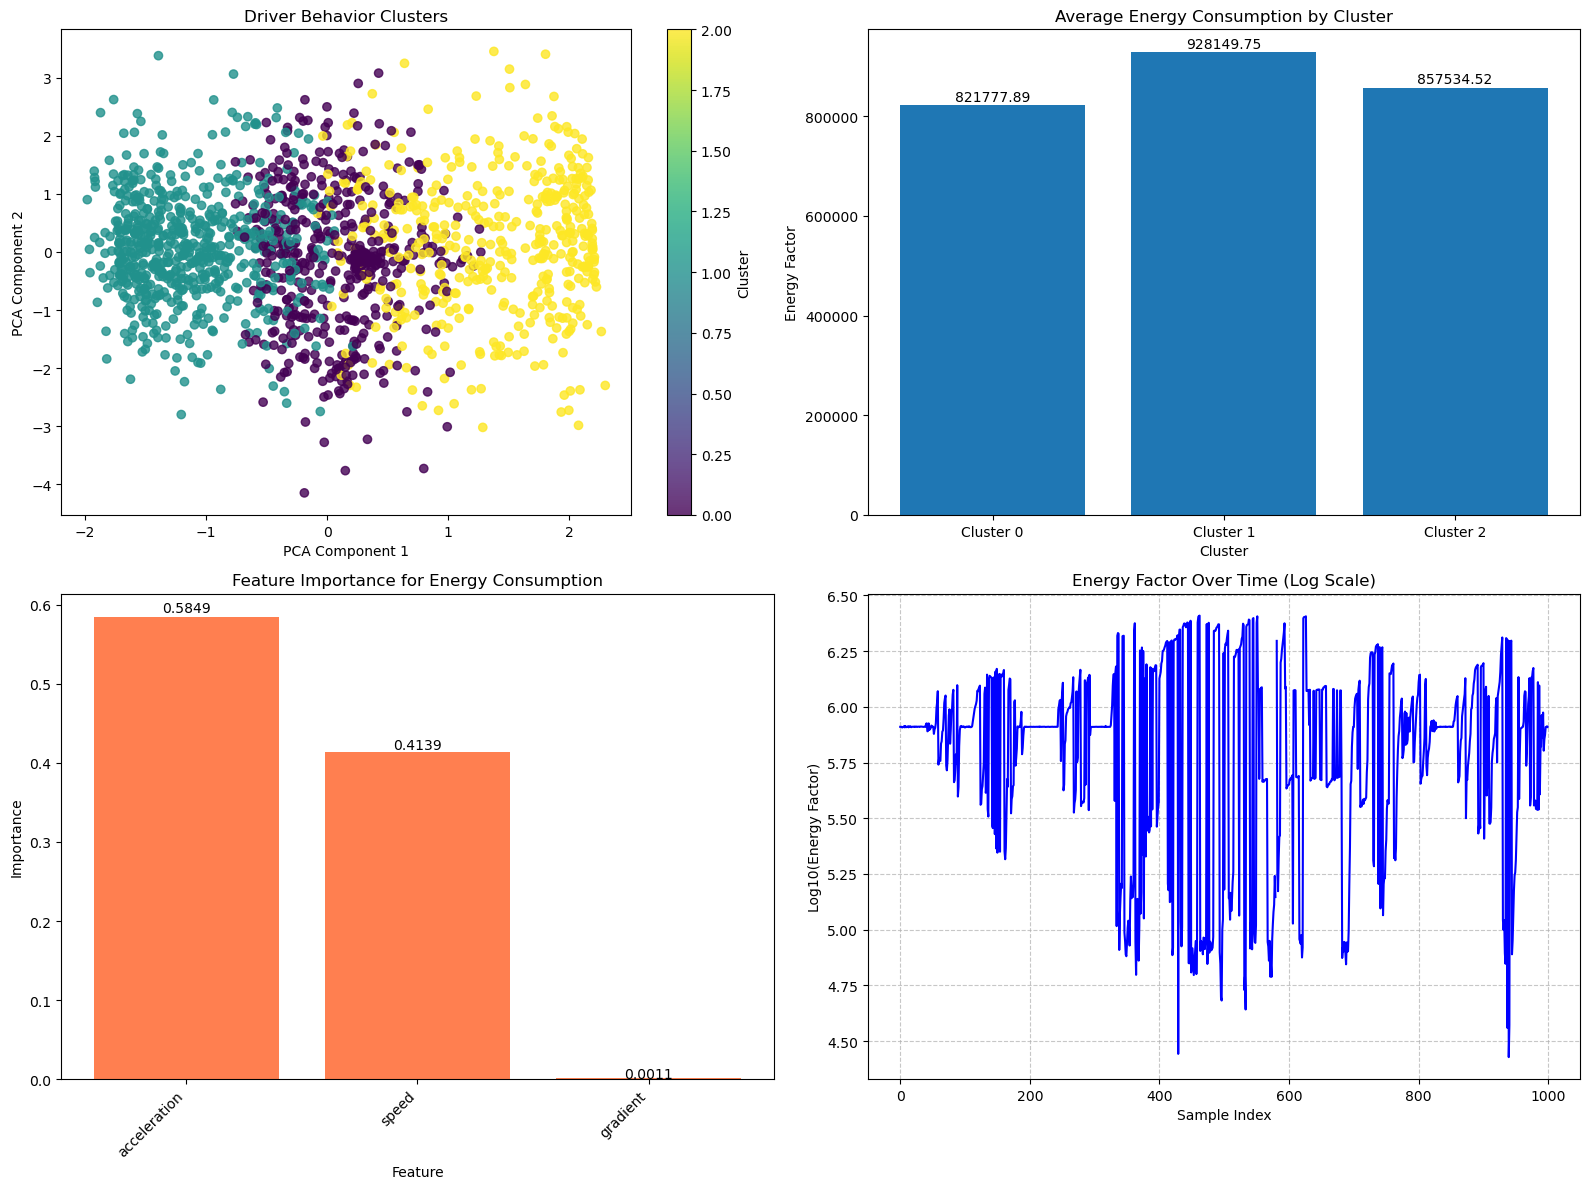

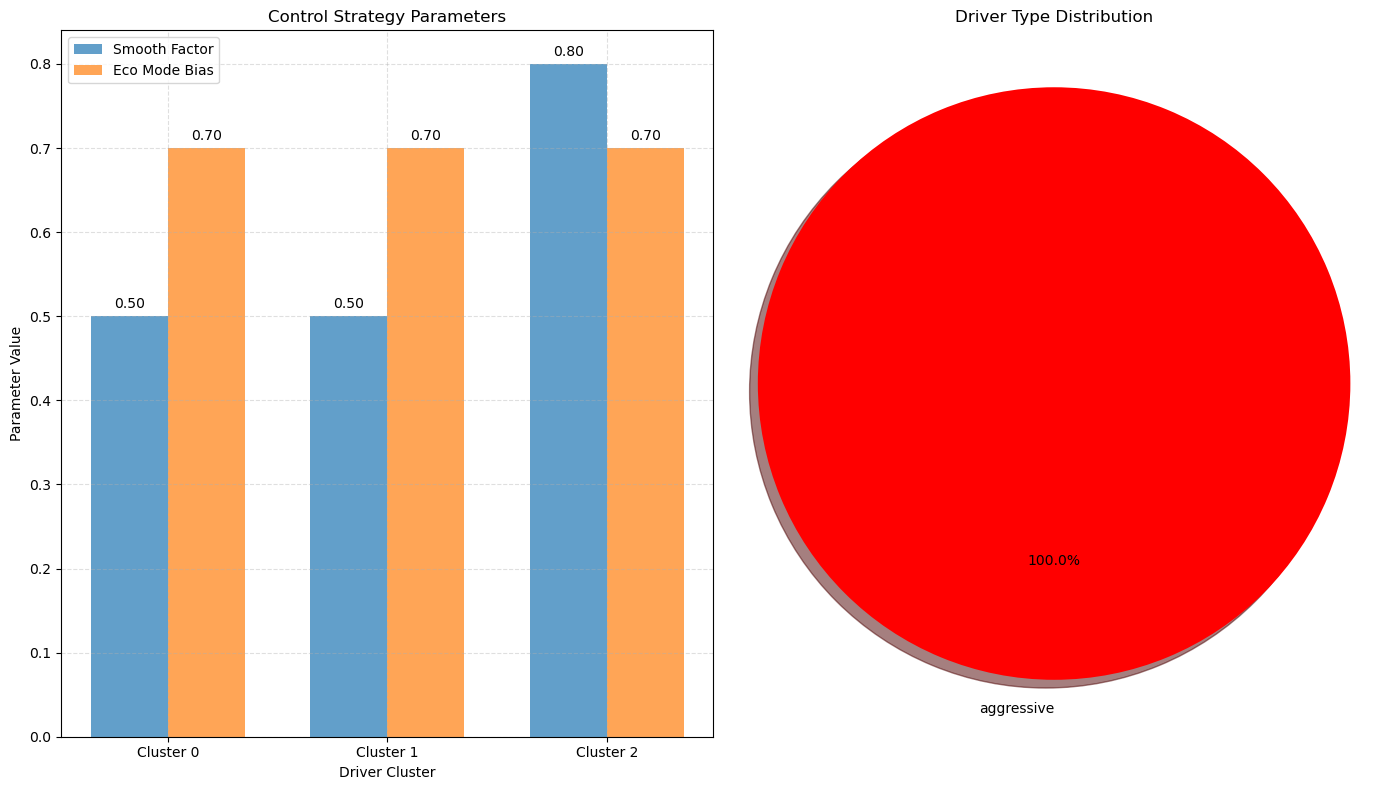

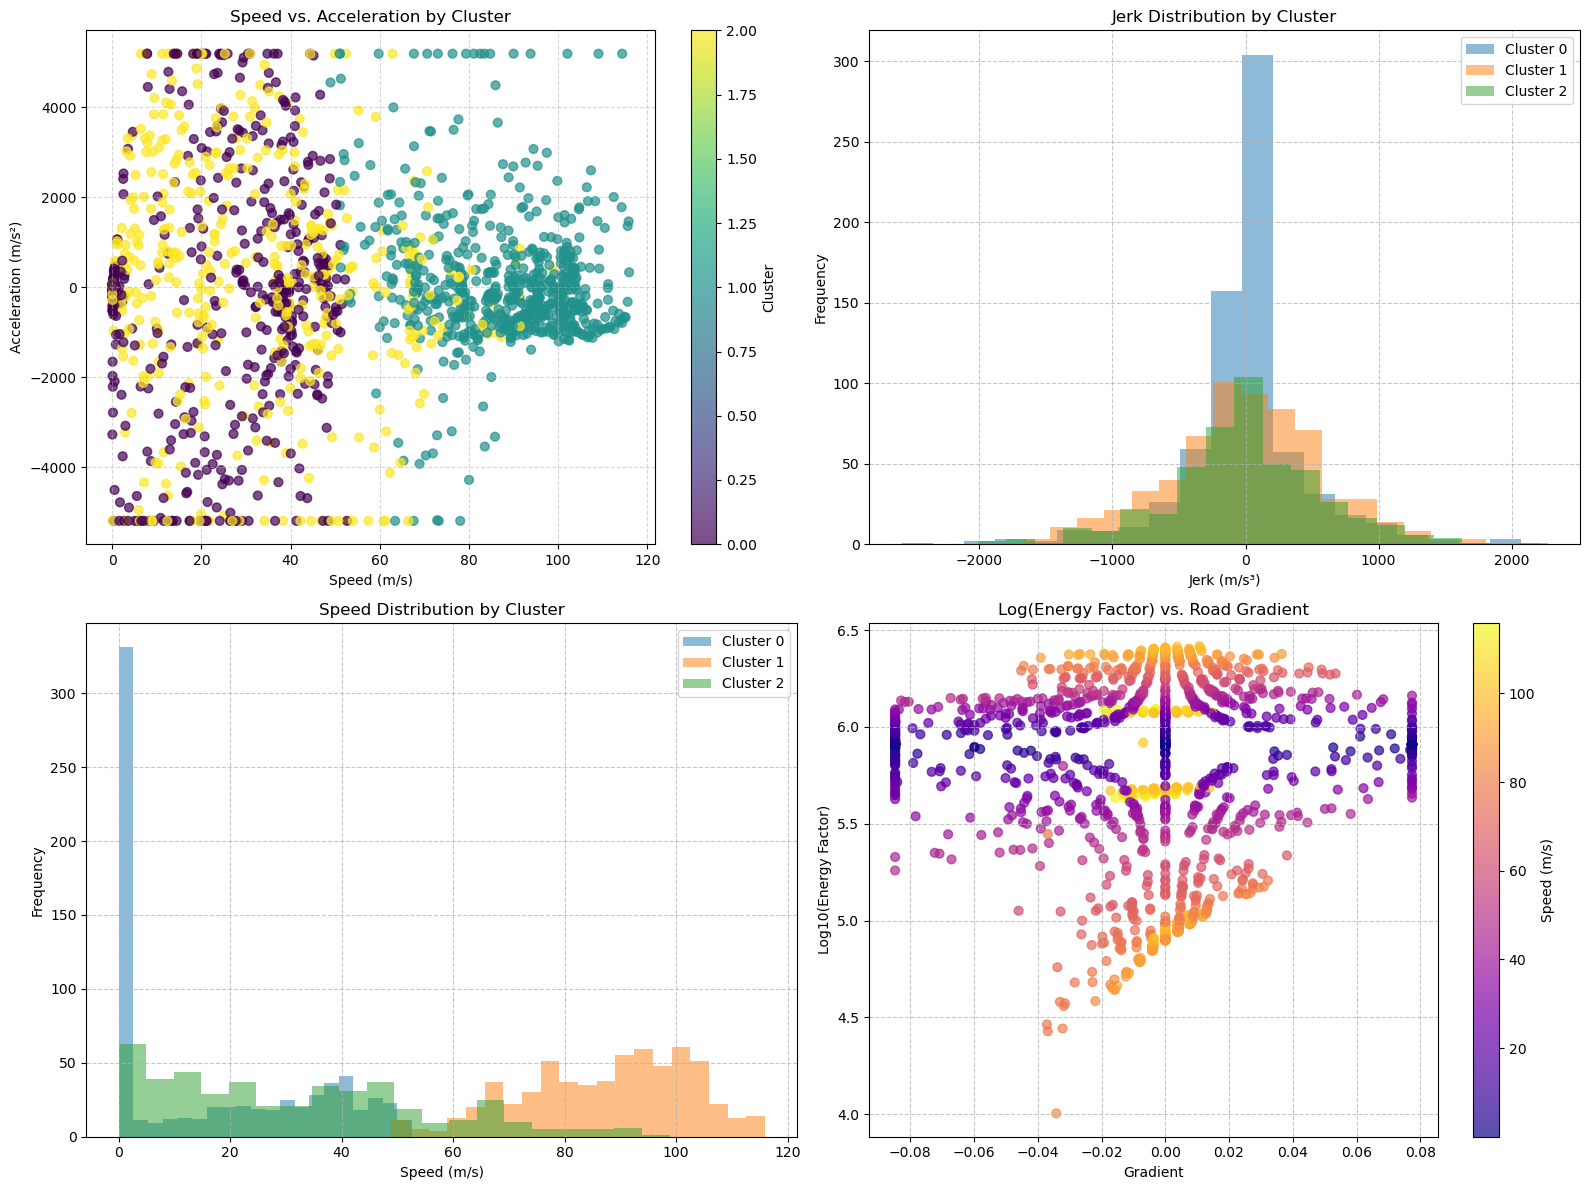

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import silhouette_score
from geopy.distance import geodesic
import traceback

# Constants for validation and processing
# 设置常量用于数据验证和处理
MAX_TIME_DIFF = 1000  # Maximum allowed time difference for data synchronization (ms)
MIN_SAMPLES_PER_CLUSTER = 5  # Minimum samples required per cluster
MAX_ACCELERATION = 20  # Maximum reasonable acceleration in m/s²
MAX_ANGULAR_VELOCITY = 10  # Maximum reasonable angular velocity in rad/s
MAX_OUTLIER_IQR = 3.0  # IQR multiplier for outlier detection

def parse_data(file_path):
    """
    Parse sensor data from the given file path.
    解析给定文件路径中的传感器数据。
    
    Args:
        file_path: Path to the CSV data file
        
    Returns:
        Dictionary containing DataFrames for different sensor types
    """
    gps_rows = []
    acc_rows = []  
    gyro_rows = []
    rot_rows = []
    
    # 用于记录数据格式不正确的行数
    invalid_lines = 0
    
    with open(file_path, 'r') as file:
        line_number = 0
        for line in file:
            line_number += 1
            values = line.strip().split(',')
            
            # Check for minimum required fields
            # 检查最小所需字段数
            if len(values) < 2:
                invalid_lines += 1
                continue
            
            try:
                data_type = int(values[0])
                
                # Validate data format based on type
                # 根据数据类型验证数据格式
                if data_type == 0:  # GPS data
                    if len(values) != 7:
                        print(f"Warning: Invalid GPS data format at line {line_number}: {line.strip()}")
                        invalid_lines += 1
                        continue
                    gps_rows.append(values)
                elif data_type == 1:  # Accelerometer data
                    if len(values) != 6:
                        print(f"Warning: Invalid accelerometer data format at line {line_number}: {line.strip()}")
                        invalid_lines += 1
                        continue
                    acc_rows.append(values)
                elif data_type == 2:  # Gyroscope data
                    if len(values) != 6:
                        print(f"Warning: Invalid gyroscope data format at line {line_number}: {line.strip()}")
                        invalid_lines += 1
                        continue
                    gyro_rows.append(values)
                elif data_type == 3:  # Rotation vector data
                    if len(values) != 7:
                        print(f"Warning: Invalid rotation vector data format at line {line_number}: {line.strip()}")
                        invalid_lines += 1
                        continue
                    rot_rows.append(values)
                else:
                    print(f"Warning: Unknown data type {data_type} at line {line_number}")
                    invalid_lines += 1
            except ValueError as e:
                print(f"Error parsing line {line_number}: {e}")
                invalid_lines += 1
    
    if invalid_lines > 0:
        print(f"Total invalid lines skipped: {invalid_lines}")
    
    # Process GPS data
    # 处理GPS数据
    gps_df = pd.DataFrame()
    if gps_rows:
        gps_df = pd.DataFrame(gps_rows)
        gps_df.columns = ['data_type', 'timestamp', 'latitude', 'longitude', 'altitude', 'speed', 'satellites']
        
        # Convert to appropriate data types
        # 转换为适当的数据类型
        gps_df['data_type'] = gps_df['data_type'].astype(int)
        gps_df['timestamp'] = gps_df['timestamp'].astype(int)
        gps_df['latitude'] = gps_df['latitude'].astype(float)
        gps_df['longitude'] = gps_df['longitude'].astype(float)
        gps_df['altitude'] = gps_df['altitude'].astype(float)
        gps_df['speed'] = gps_df['speed'].astype(float)
        gps_df['satellites'] = gps_df['satellites'].astype(int)
        
        # Convert speed from m/s to km/h
        # 将速度从m/s转换为km/h
        gps_df['speed_kmh'] = gps_df['speed'] *3.6
    else:
        print("Warning: No GPS data found in the file")
    
    # Process accelerometer data
    # 处理加速度计数据
    acc_df = pd.DataFrame()
    if acc_rows:
        acc_df = pd.DataFrame(acc_rows)
        acc_df.columns = ['data_type', 'timestamp', 'timestamp_us', 'x', 'y', 'z']
        acc_df['data_type'] = acc_df['data_type'].astype(int)
        acc_df['timestamp'] = acc_df['timestamp'].astype(int)
        acc_df['timestamp_us'] = acc_df['timestamp_us'].astype(int)
        acc_df['x'] = acc_df['x'].astype(float)
        acc_df['y'] = acc_df['y'].astype(float)
        acc_df['z'] = acc_df['z'].astype(float)
      
        # Note: x, y, z values are already in m/s², no need for conversion
        # 注意：x、y、z值已经是m/s²单位，不需要转换
    else:
        print("Warning: No accelerometer data found in the file")
    
    # Process gyroscope data
    # 处理陀螺仪数据 
    gyro_df = pd.DataFrame()
    if gyro_rows:
        gyro_df = pd.DataFrame(gyro_rows)
        gyro_df.columns = ['data_type', 'timestamp', 'timestamp_us', 'x', 'y', 'z']
        gyro_df['data_type'] = gyro_df['data_type'].astype(int)
        gyro_df['timestamp'] = gyro_df['timestamp'].astype(int)
        gyro_df['timestamp_us'] = gyro_df['timestamp_us'].astype(int)
        gyro_df['x'] = gyro_df['x'].astype(float)
        gyro_df['y'] = gyro_df['y'].astype(float)
        gyro_df['z'] = gyro_df['z'].astype(float)
        
        # Note: gyroscope values are already in rad/s, no need for conversion
        # 注意：陀螺仪值已经是rad/s单位，不需要转换
    else:
        print("Warning: No gyroscope data found in the file")
    
    # Process rotation vector data
    # 处理旋转向量数据
    rot_df = pd.DataFrame()
    if rot_rows:
        rot_df = pd.DataFrame(rot_rows)
        rot_df.columns = ['data_type', 'timestamp', 'timestamp_us', 'i', 'j', 'k', 'real']
        
        rot_df['data_type'] = rot_df['data_type'].astype(int)
        rot_df['timestamp'] = rot_df['timestamp'].astype(int)
        rot_df['timestamp_us'] = rot_df['timestamp_us'].astype(int)
        rot_df['i'] = rot_df['i'].astype(float)
        rot_df['j'] = rot_df['j'].astype(float)
        rot_df['k'] = rot_df['k'].astype(float)
        rot_df['real'] = rot_df['real'].astype(float)
    else:
        print("Warning: No rotation vector data found in the file")
    
    # Check time range consistency between different sensors
    # 检查不同传感器之间的时间范围一致性
    if not gps_df.empty and not acc_df.empty:
        gps_time_range = (gps_df['timestamp'].min(), gps_df['timestamp'].max())
        acc_time_range = (acc_df['timestamp'].min(), acc_df['timestamp'].max())
        
        # Check if time ranges overlap
        # 检查时间范围是否重叠
        if (gps_time_range[1] < acc_time_range[0]) or (acc_time_range[1] < gps_time_range[0]):
            print("Warning: GPS and accelerometer data have non-overlapping time ranges")
            print(f"GPS time range: {gps_time_range}")
            print(f"Accelerometer time range: {acc_time_range}")
    
    print(f"Parsed data summary:")
    print(f"GPS data: {len(gps_df)} records")
    print(f"Accelerometer data: {len(acc_df)} records")
    print(f"Gyroscope data: {len(gyro_df)} records")
    print(f"Rotation vector data: {len(rot_df)} records")
    
    return {
        'gps': gps_df,
        'acc': acc_df,
        'gyro': gyro_df,
        'rot': rot_df
    }

def check_missing_values(data_dict):
    """
    Check for missing values and data quality issues in the parsed data.
    检查解析数据中的缺失值和数据质量问题。
    
    Args:
        data_dict: Dictionary containing DataFrames for different sensor types
    """
    print("\n" + "="*50)
    print("DETAILED DATA INSPECTION")
    print("="*50)
    
    for data_type, df in data_dict.items():
        print(f"\n{'='*20} {data_type.upper()} DATA {'='*20}")
        
        if df.empty:
            print(f"No {data_type} data available.")
            continue
        
        print(f"Shape: {df.shape} (rows, columns)")
        
        print(f"Columns: {list(df.columns)}")
        
        # Check for missing values
        # 检查缺失值
        missing = df.isna().sum()
        print(f"\n{data_type.upper()} missing values:")
        for col, count in missing.items():
            print(f"  {col}: {count}")
        
        # Basic statistics
        # 基本统计信息
        print(f"\n{data_type.upper()} basic statistics:")
        print(df.describe())
        
        # Check for duplicates
        # 检查重复值
        duplicates = df.duplicated().sum()
        print(f"\nDuplicate rows in {data_type} data: {duplicates}")
        
        # Data validity checks
        # 数据有效性检查
        print(f"\nData validity checks for {data_type} data:")
        
        if data_type == 'gps':
            invalid_lat = df[(df['latitude'] < -90) | (df['latitude'] > 90)].shape[0]
            invalid_lon = df[(df['longitude'] < -180) | (df['longitude'] > 180)].shape[0]
            print(f"  Invalid latitude values: {invalid_lat}")
            print(f"  Invalid longitude values: {invalid_lon}")
            
            if 'speed' in df.columns:
                extreme_speed = df[df['speed'] > 300].shape[0]
                print(f"  Extreme speed values (>300 m/s): {extreme_speed}")
            
            # Check for unrealistic jumps in location
            # 检查位置的不合理跳跃
            if len(df) > 1:
                df_sorted = df.sort_values('timestamp')
                lat_diff = df_sorted['latitude'].diff().abs()
                lon_diff = df_sorted['longitude'].diff().abs()
                
                # A difference of 0.1 degrees is roughly 11km
                # 0.1度的差异大约是11公里
                large_jumps = ((lat_diff > 0.1) | (lon_diff > 0.1)).sum()
                print(f"  Large position jumps (>~11km): {large_jumps}")
        
        elif data_type == 'acc':
            extreme_acc = df[(df['x'].abs() > MAX_ACCELERATION) | 
                             (df['y'].abs() > MAX_ACCELERATION) | 
                             (df['z'].abs() > MAX_ACCELERATION)].shape[0]
            print(f"  Extreme acceleration values (>{MAX_ACCELERATION} m/s²): {extreme_acc}")
            
            # Check for periods of constant values (potential sensor errors)
            # 检查恒定值的周期（潜在的传感器错误）
            constant_x = (df['x'].diff() == 0).sum()
            constant_y = (df['y'].diff() == 0).sum()
            constant_z = (df['z'].diff() == 0).sum()
            print(f"  Constant consecutive values: x={constant_x}, y={constant_y}, z={constant_z}")
        
        elif data_type == 'gyro':
            extreme_gyro = df[(df['x'].abs() > MAX_ANGULAR_VELOCITY) | 
                               (df['y'].abs() > MAX_ANGULAR_VELOCITY) | 
                               (df['z'].abs() > MAX_ANGULAR_VELOCITY)].shape[0]
            print(f"  Extreme angular velocity values (>{MAX_ANGULAR_VELOCITY} rad/s): {extreme_gyro}")
        
        elif data_type == 'rot':
            # Quaternion components should normally have magnitude <= 1
            # 四元数分量通常幅度应<=1
            extreme_rot = df[(df['i'].abs() > 1) | (df['j'].abs() > 1) | 
                              (df['k'].abs() > 1) | (df['real'].abs() > 1)].shape[0]
            print(f"  Potentially unusual rotation vector values: {extreme_rot}")
            
            # Check if quaternions are normalized (i²+j²+k²+real² should be close to 1)
            # 检查四元数是否标准化（i²+j²+k²+real²应接近1）
            quaternion_norm = np.sqrt(df['i']**2 + df['j']**2 + df['k']**2 + df['real']**2)
            non_normalized = ((quaternion_norm < 0.98) | (quaternion_norm > 1.02)).sum()
            print(f"  Non-normalized quaternions: {non_normalized}")
        
        # Check timestamp sequence
        # 检查时间戳序列
        if 'timestamp' in df.columns:
            is_sorted = df['timestamp'].is_monotonic_increasing
            print(f"  Timestamp in chronological order: {is_sorted}")
            
            if not is_sorted:
                reversed_timestamps = (df['timestamp'].diff() < 0).sum()
                print(f"  Number of reversed timestamp pairs: {reversed_timestamps}")
                
                # Sort by timestamp for further processing
                # 按时间戳排序以进行进一步处理
                print("  Sorting data by timestamp for further processing")
                df.sort_values('timestamp', inplace=True)
                
            # Check for unusually large time gaps
            # 检查异常大的时间间隔
            time_diffs = df['timestamp'].diff()
            large_gaps = (time_diffs > 5000).sum()  # gaps > 5 seconds
            print(f"  Large time gaps (>5s): {large_gaps}")
            
            # Check data rate and consistency
            # 检查数据率和一致性
            if len(time_diffs) > 1:
                median_interval = time_diffs.median()
                p95_interval = time_diffs.quantile(0.95)
                print(f"  Median sampling interval: {median_interval:.2f} ms")
                print(f"  95th percentile interval: {p95_interval:.2f} ms")
    
    print("\n" + "="*50)
    print("END OF DATA INSPECTION")
    print("="*50)

def clean_outliers(df, columns, method='iqr'):
    """
    Clean outliers from specified columns using IQR or Z-score method.
    使用IQR或Z-score方法清除指定列中的异常值。
    
    Args:
        df: DataFrame to clean
        columns: List of column names to check for outliers
        method: 'iqr' or 'zscore'
    
    Returns:
        Cleaned DataFrame
    """
    df_clean = df.copy()
    
    # Track how many outliers are replaced
    # 跟踪替换了多少异常值
    outlier_counts = {}
    
    for col in columns:
        if col not in df.columns:
            continue
            
        if method == 'iqr':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - MAX_OUTLIER_IQR * IQR
            upper_bound = Q3 + MAX_OUTLIER_IQR * IQR
            
            # Count outliers
            # 计算异常值数量
            outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
            outlier_counts[col] = outliers
            
            # Replace outliers with bounds
            # 用边界值替换异常值
            df_clean.loc[df_clean[col] < lower_bound, col] = lower_bound
            df_clean.loc[df_clean[col] > upper_bound, col] = upper_bound
            
        elif method == 'zscore':
            mean = df[col].mean()
            std = df[col].std()
            
            # Using 3 standard deviations as threshold
            # 使用3个标准差作为阈值
            lower_bound = mean - 3 * std
            upper_bound = mean + 3 * std
            
            # Count outliers
            # 计算异常值数量
            outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
            outlier_counts[col] = outliers
            
            # Replace outliers with bounds
            # 用边界值替换异常值
            df_clean.loc[df_clean[col] < lower_bound, col] = lower_bound
            df_clean.loc[df_clean[col] > upper_bound, col] = upper_bound
    
    print("Outlier detection summary:")
    for col, count in outlier_counts.items():
        print(f"  {col}: {count} outliers detected and replaced")
        
    return df_clean

def extract_features(data_dict):
    """
    Extract features from the sensor data for eco-driving analysis.
    从传感器数据中提取特征用于节能驾驶分析。
    
    Args:
        data_dict: Dictionary containing DataFrames for different sensor types
        
    Returns:
        Dictionary containing extracted feature DataFrames
    """
    features = {}
    
    # Process GPS data if available
    # 处理GPS数据（如果可用）
    if not data_dict['gps'].empty:
        gps_df = data_dict['gps'].copy()
        
        # Sort by timestamp to ensure correct calculations
        # 按时间戳排序以确保正确计算
        gps_df.sort_values('timestamp', inplace=True)
        
        # Calculate distance and gradient between consecutive points
        # 计算连续点之间的距离和坡度
        distances = []
        gradients = []
        
        for i in range(1, len(gps_df)):
            point1 = (gps_df['latitude'].iloc[i-1], gps_df['longitude'].iloc[i-1])
            point2 = (gps_df['latitude'].iloc[i], gps_df['longitude'].iloc[i])
            
            try:
                distance = geodesic(point1, point2).meters
                
                # Skip unrealistic jumps (likely GPS errors)
                # 跳过不现实的跳跃（可能是GPS错误）
                if distance > 100 and i > 1:  # >100m jump
                    prev_distance = distances[-1]
                    # Use previous distance if current is an outlier
                    # 如果当前距离是异常值，则使用前一个距离
                    distance = prev_distance
                    
                distances.append(distance)
                
                # Calculate road gradient (slope)
                # 计算道路坡度
                if distance > 0:
                    elevation_change = gps_df['altitude'].iloc[i] - gps_df['altitude'].iloc[i-1]
                    gradient = elevation_change / distance
                    
                    # Limit unrealistic gradients (>45° or <-45° is unlikely on roads)
                    # 限制不现实的坡度（>45°或<-45°在道路上不太可能）
                    gradient = max(min(gradient, 1.0), -1.0)
                else:
                    gradient = 0
                    
                gradients.append(gradient)
                
            except Exception as e:
                print(f"Error calculating distance at indices {i-1}-{i}: {e}")
                distances.append(0 if i == 1 else distances[-1])
                gradients.append(0)
        
        # Add calculated values to dataframe
        # 将计算值添加到数据框
        gps_df.loc[1:, 'distance'] = distances
        gps_df.loc[1:, 'gradient'] = gradients
        gps_df.loc[0, 'distance'] = 0
        gps_df.loc[0, 'gradient'] = 0
        
        # Calculate acceleration from speed changes
        # 根据速度变化计算加速度
        gps_df['speed_change'] = gps_df['speed'].diff().fillna(0)
        
        # Calculate time difference in seconds
        # 计算时间差（以秒为单位）
        time_diff = gps_df['timestamp'].diff().fillna(1) / 1000  # convert ms to s
        gps_df['acceleration'] = gps_df['speed_change'] / time_diff
        
        # Clean outliers in the calculated features
        # 清除计算特征中的异常值
        gps_df = clean_outliers(gps_df, ['acceleration', 'gradient'], method='iqr')
        
        features['route'] = gps_df
    
    # Process accelerometer data if available
    # 处理加速度计数据（如果可用）
    if not data_dict['acc'].empty:
        acc_df = data_dict['acc'].copy()
        
        # Sort by timestamp
        # 按时间戳排序
        acc_df.sort_values('timestamp', inplace=True)
        
        # Clean outliers before calculating derived features
        # 在计算派生特征之前清除异常值
        acc_df = clean_outliers(acc_df, ['x', 'y', 'z'], method='iqr')
        
        # Calculate acceleration magnitude
        # 计算加速度幅值
        acc_df['magnitude'] = np.sqrt(acc_df['x']**2 + acc_df['y']**2 + acc_df['z']**2)
        
        # Calculate jerk (rate of change of acceleration)
        # 计算加加速度（加速度变化率）
        time_diff = acc_df['timestamp'].diff().fillna(1) / 1000  # convert ms to s
        acc_df['jerk'] = acc_df['magnitude'].diff().fillna(0) / time_diff
        
        # Apply Savitzky-Golay filter to smooth the jerk data
        # 应用Savitzky-Golay滤波器平滑加加速度数据
        if len(acc_df) > 5:  # Need enough points for filtering
            window_size = min(21, len(acc_df) - (len(acc_df) % 2) - 1)
            # Ensure window_size is odd
            # 确保窗口大小为奇数
            if window_size % 2 == 0:
                window_size -= 1
                
            if window_size >= 3:  # Need at least window size 3
                try:
                    acc_df['jerk_smooth'] = savgol_filter(acc_df['jerk'], window_size, 3)
                except Exception as e:
                    print(f"Error applying Savitzky-Golay filter: {e}")
                    acc_df['jerk_smooth'] = acc_df['jerk']
            else:
                acc_df['jerk_smooth'] = acc_df['jerk']
        else:
            acc_df['jerk_smooth'] = acc_df['jerk']
        
        features['behavior'] = acc_df
    
    # Process gyroscope data if available
    # 处理陀螺仪数据（如果可用）
    if not data_dict['gyro'].empty:
        gyro_df = data_dict['gyro'].copy()
        
        # Sort by timestamp
        # 按时间戳排序
        gyro_df.sort_values('timestamp', inplace=True)
        
        # Clean outliers
        # 清除异常值
        gyro_df = clean_outliers(gyro_df, ['x', 'y', 'z'], method='iqr')
        
        # Calculate turning rate (absolute value of angular velocity around z-axis)
        # 计算转向率（绕z轴角速度的绝对值）
        gyro_df['turning_rate'] = np.abs(gyro_df['z'])
        
        # Calculate total angular velocity
        # 计算总角速度
        gyro_df['angular_velocity'] = np.sqrt(gyro_df['x']**2 + gyro_df['y']**2 + gyro_df['z']**2)
        
        features['turning'] = gyro_df
    
    return features

def model_energy_consumption(features):
    """
    Model energy consumption based on extracted features.
    基于提取的特征建模能耗。
    
    Args:
        features: Dictionary containing feature DataFrames
        
    Returns:
        DataFrame with synchronized data and energy consumption factors
    """
    # Check if we have the necessary data
    # 检查是否有必要的数据
    if 'route' in features and 'behavior' in features:
        route_df = features['route']
        behavior_df = features['behavior']
        
        route_times = route_df['timestamp'].values
        behavior_times = behavior_df['timestamp'].values
        
        combined_data = []
        skipped_points = 0
        
        for i, row in route_df.iterrows():
            gps_time = row['timestamp']
            
            # Find closest accelerometer data point
            # 找到最接近的加速度计数据点
            time_diff = np.abs(behavior_times - gps_time)
            closest_acc_idx = np.argmin(time_diff)
            
            # Skip if time difference is too large
            # 如果时间差太大，则跳过
            if time_diff[closest_acc_idx] > MAX_TIME_DIFF:
                skipped_points += 1
                continue
            
            entry = {
                'timestamp': gps_time,
                'speed': row['speed'],
                'speed_kmh': row.get('speed_kmh', row['speed'] * 3.6),
                'acceleration': row['acceleration'],
                'gradient': row['gradient'],
                'acc_x': behavior_df['x'].iloc[closest_acc_idx],
                'acc_y': behavior_df['y'].iloc[closest_acc_idx],
                'acc_z': behavior_df['z'].iloc[closest_acc_idx],
                'jerk': behavior_df.get('jerk_smooth', behavior_df['jerk']).iloc[closest_acc_idx]
            }
            
            # Add turning data if available
            # 如果有转向数据，则添加
            if 'turning' in features:
                turning_df = features['turning']
                turning_times = turning_df['timestamp'].values
                
                # Find closest gyroscope data point
                # 找到最接近的陀螺仪数据点
                closest_turn_idx = np.argmin(np.abs(turning_times - gps_time))
                
                # Only include if time difference is reasonable
                # 仅在时间差合理时包含
                if np.abs(turning_times[closest_turn_idx] - gps_time) <= MAX_TIME_DIFF:
                    entry['turning_rate'] = turning_df['turning_rate'].iloc[closest_turn_idx]
                    entry['angular_velocity'] = turning_df['angular_velocity'].iloc[closest_turn_idx]
                else:
                    entry['turning_rate'] = 0
                    entry['angular_velocity'] = 0
            else:
                entry['turning_rate'] = 0
                entry['angular_velocity'] = 0
                
            combined_data.append(entry)
        
        if skipped_points > 0:
            print(f"Skipped {skipped_points} points due to large time differences")
            
        if not combined_data:
            print("Warning: No synchronized data points available")
            return pd.DataFrame()
            
        # Convert to DataFrame
        # 转换为DataFrame
        combined_df = pd.DataFrame(combined_data)
        
        # Calculate energy factors
        # 计算能量因子
        combined_df['energy_factor'] = calculate_energy_factors(combined_df)
        
        return combined_df
    else:
        print("Error: Missing required feature data (route or behavior)")
        return pd.DataFrame()

def calculate_energy_factors(df):
    """
    Calculate energy consumption factors based on physics model.
    基于物理模型计算能耗因子。
    
    Args:
        df: DataFrame with speed, acceleration, gradient, etc.
        
    Returns:
        Series with energy factors
    """
    # Vehicle parameters (typical values for a medium-sized electric vehicle)
    # 车辆参数（中型电动汽车的典型值）
    mass = 2500  # kg
    g = 9.81  # m/s²
    rho = 1.225  # air density, kg/m³
    Cd = 0.319  # drag coefficient
    A = 2.54  # frontal area, m²
    Cr = 0.013  # rolling resistance coefficient
    
    energy_factors = np.zeros(len(df))
    
    for i in range(len(df)):
        # Convert speed to m/s if in km/h
        # 如果速度单位为km/h，则转换为m/s
        if 'speed_kmh' in df.columns and df['speed'].iloc[i] > 100:  # Likely in km/h
            speed = df['speed'].iloc[i] / 3.6
        else:
            speed = df['speed'].iloc[i]
        
        if speed < 0:
            speed = 0  # Ensure non-negative speed
        
        # Calculate resistances
        # 计算阻力
        
        # 1. Rolling resistance
        # 滚动阻力
        gradient_angle = np.arctan(df['gradient'].iloc[i])
        rolling_resistance = Cr * mass * g * np.cos(gradient_angle)
        
        # 2. Aerodynamic drag
        # 气动阻力
        aero_drag = 0.5 * rho * Cd * A * speed**2
        
        # 3. Gradient resistance
        # 坡度阻力
        gradient_resistance = mass * g * np.sin(gradient_angle)
        
        # 4. Acceleration resistance
        # 加速阻力
        acceleration = df['acceleration'].iloc[i]
        # Limit unrealistic accelerations
        # 限制不现实的加速度
        acceleration = max(min(acceleration, 5), -5)
        acceleration_resistance = mass * acceleration
        
        # Sum all resistances and multiply by speed to get power
        # 将所有阻力相加并乘以速度得到功率
        total_resistance = rolling_resistance + aero_drag + gradient_resistance + acceleration_resistance
        
        # Mechanical power needed (W = F * v)
        # 需要的机械功率（W = F * v）
        energy_factors[i] = total_resistance * speed
    
    # Normalize to positive values (for clustering purposes)
    # 归一化为正值（用于聚类目的）
    min_energy = np.min(energy_factors)
    if min_energy < 0:
        energy_factors = energy_factors - min_energy
    
    return energy_factors

def cluster_driving_behaviors(combined_data, n_clusters=3):
    """
    Cluster drivers based on their driving behavior patterns.
    根据驾驶行为模式对驾驶员进行聚类。
    
    Args:
        combined_data: DataFrame with synchronized sensor data
        n_clusters: Number of clusters to form
        
    Returns:
        Tuple of (clustered data, cluster profiles, PCA data, cluster labels)
    """
    # Basic features for clustering
    # 用于聚类的基本特征
    features = ['speed', 'acceleration', 'jerk', 'turning_rate']
    
    # Check if all required features are present
    # 检查是否存在所有所需特征
    for feature in features:
        if feature not in combined_data.columns:
            print(f"Warning: '{feature}' column not found. Adding with default value 0.")
            combined_data[feature] = 0.0
    
    # Extract features for clustering
    # 提取聚类特征
    X = combined_data[features].copy()
    
    # Check for missing values
    # 检查缺失值
    print("Checking for missing values...")
    missing_values = X.isna().sum()
    print(f"Missing values in features: {missing_values}")
    
    if missing_values.sum() > 0:
        print("Filling missing values with column means...")
        # First try to fill with column means
        # 首先尝试用列均值填充
        for col in X.columns:
            if X[col].isna().any():
                if X[col].notna().any():
                    X[col] = X[col].fillna(X[col].mean())
                else:
                    # If column is all NaN, fill with zeros
                    # 如果列全为NaN，则填充为零
                    X[col] = X[col].fillna(0)
                    
        print("After filling, missing values:", X.isna().sum())
    
    # Check for sufficient data
    # 检查数据是否足够
    if len(X) < n_clusters * MIN_SAMPLES_PER_CLUSTER:
        print(f"Warning: Not enough data points ({len(X)}) for {n_clusters} clusters.")
        n_clusters = max(1, len(X) // MIN_SAMPLES_PER_CLUSTER)
        print(f"Reducing to {n_clusters} clusters.")
    
    # Scale the features
    # 缩放特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply PCA for visualization
    # 应用PCA进行可视化
    try:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        explained_variance = pca.explained_variance_ratio_
        print(f"PCA explained variance: {explained_variance[0]:.2f}, {explained_variance[1]:.2f}")
        print("PCA completed successfully.")
    except Exception as e:
        print(f"Error during PCA: {e}")
        print("Using the first two standardized features instead.")
        X_pca = X_scaled[:, :2]
    
    # Limit number of clusters based on data size
    # 根据数据大小限制聚类数量
    n_clusters = min(n_clusters, max(1, len(X) - 1))
    print(f"Clustering into {n_clusters} groups...")
    
    # If only one cluster is possible, skip KMeans
    # 如果只有一个可能的聚类，则跳过KMeans
    if n_clusters == 1:
        clusters = np.zeros(len(X), dtype=int)
        silhouette = 0  # No silhouette score for single cluster
    else:
        # Apply KMeans clustering
        # 应用KMeans聚类
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(X_scaled)
        
        # Evaluate clustering quality
        # 评估聚类质量
        try:
            silhouette = silhouette_score(X_scaled, clusters)
            print(f"Silhouette score: {silhouette:.3f}")
            
            if silhouette < 0.2:
                print("Warning: Low silhouette score indicates poor cluster separation.")
                print("Consider adjusting feature selection or reducing number of clusters.")
        except Exception as e:
            print(f"Could not calculate silhouette score: {e}")
            silhouette = 0
    
    # Add cluster labels to data
    # 将聚类标签添加到数据中
    combined_data['driver_cluster'] = clusters
    
    # Calculate cluster profiles
    # 计算聚类概况
    cluster_profiles = {}
    
    for cluster in range(n_clusters):
        cluster_data = combined_data[combined_data['driver_cluster'] == cluster]
        
        if len(cluster_data) > 0:
            profile = {
                'count': len(cluster_data),
                'avg_speed': cluster_data['speed'].mean(),
                'avg_acceleration': cluster_data['acceleration'].mean(),
                'avg_jerk': cluster_data['jerk'].mean() if 'jerk' in cluster_data.columns else 0.0,
                'avg_turning_rate': cluster_data['turning_rate'].mean() if 'turning_rate' in cluster_data.columns else 0.0,
                'energy_efficiency': cluster_data['energy_factor'].mean() if 'energy_factor' in cluster_data.columns else 0.0,
                'std_speed': cluster_data['speed'].std(),
                'std_acceleration': cluster_data['acceleration'].std(),
                'max_jerk': cluster_data['jerk'].max() if 'jerk' in cluster_data.columns else 0.0
            }
        else:
            profile = {
                'count': 0,
                'avg_speed': 0.0,
                'avg_acceleration': 0.0,
                'avg_jerk': 0.0,
                'avg_turning_rate': 0.0,
                'energy_efficiency': 0.0,
                'std_speed': 0.0,
                'std_acceleration': 0.0,
                'max_jerk': 0.0
            }
        
        cluster_profiles[cluster] = profile
    
    return combined_data, cluster_profiles, X_pca, clusters, silhouette

def develop_control_strategy(combined_data, cluster_profiles):
    """
    Develop adaptive control strategies based on driver clusters.
    基于驾驶员聚类开发自适应控制策略。
    
    Args:
        combined_data: DataFrame with clustered driving data
        cluster_profiles: Dictionary with cluster statistics
        
    Returns:
        Tuple of (model, feature importance, control strategies, feature names)
    """
    # Check required columns
    # 检查所需的列
    features = ['speed', 'acceleration', 'gradient', 'turning_rate', 'driver_cluster']
    for feature in features:
        if feature not in combined_data.columns:
            print(f"Warning: '{feature}' column not found. Adding with default value 0.")
            combined_data[feature] = 0 if feature == 'driver_cluster' else 0.0
    
    # Check for energy factor
    # 检查能量因子
    if 'energy_factor' not in combined_data.columns:
        print("Warning: 'energy_factor' column not found. Adding with default values.")
        combined_data['energy_factor'] = 10.0  # Default value
    
    # Fill any remaining missing values
    # 填充任何剩余的缺失值
    for col in combined_data.columns:
        if combined_data[col].isna().any():
            print(f"Filling missing values in '{col}' column for control strategy development")
            if col == 'driver_cluster':
                combined_data[col] = combined_data[col].fillna(0).astype(int)
            else:
                combined_data[col] = combined_data[col].fillna(combined_data[col].mean() if combined_data[col].notna().any() else 0.0)
    
    # Prepare features and target for the model
    # 准备模型的特征和目标
    X = pd.get_dummies(combined_data[features], columns=['driver_cluster'])
    y = combined_data['energy_factor']
    
    feature_names = list(X.columns)
    
    # Train random forest model
    # 训练随机森林模型
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    try:
        model.fit(X, y)
        feature_importance = dict(zip(X.columns, model.feature_importances_))
        print("\nFeature importance for energy consumption:")
        for feature, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
            print(f"  {feature}: {importance:.4f}")
    except Exception as e:
        print(f"Error training energy consumption model: {e}")
        # Create dummy model and importance
        # 创建虚拟模型和重要性
        feature_importance = {feature: 1.0/len(X.columns) for feature in X.columns}
        
        # Simple dummy model that always predicts mean
        # 总是预测均值的简单虚拟模型
        class DummyModel:
            def __init__(self, mean_value):
                self.mean_value = mean_value
                
            def predict(self, X):
                return np.ones(len(X)) * self.mean_value
                
        model = DummyModel(y.mean())
    
    # Develop control strategies based on cluster profiles
    # 基于聚类概况开发控制策略
    control_strategies = {}
    
    for cluster, profile in cluster_profiles.items():
        avg_jerk = profile.get('avg_jerk', 0.0)
        avg_acceleration = profile.get('avg_acceleration', 0.0)
        avg_turning_rate = profile.get('avg_turning_rate', 0.0)
        avg_speed = profile.get('avg_speed', 30.0)
        std_acceleration = profile.get('std_acceleration', 0.5)
        energy_efficiency = profile.get('energy_efficiency', 10.0)
        
        # Classify driver type and define appropriate control strategy
        # 分类驾驶员类型并定义适当的控制策略
        if avg_jerk > 0.5 or std_acceleration > 0.8:  
            # Aggressive driver
            # 激进驾驶员
            strategy = {
                'driver_type': 'aggressive',
                'acceleration_smoothing': True,
                'smooth_factor': min(0.8, 0.3 + avg_jerk / 3) if avg_jerk > 0 else 0.5,
                'anticipation_distance': 100 + (avg_speed * 5),
                'eco_mode_bias': 0.7,
                'jerk_limit': 0.3,
                'notes': 'High jerk and acceleration variation indicate aggressive driving'
            }
        elif avg_acceleration > 0.8: 
            # Dynamic driver
            # 动态驾驶员
            strategy = {
                'driver_type': 'dynamic',
                'acceleration_smoothing': True,
                'smooth_factor': 0.4,
                'anticipation_distance': 80 + (avg_speed * 3),
                'eco_mode_bias': 0.6,
                'jerk_limit': 0.5,
                'notes': 'Higher than average acceleration but smooth driving'
            }
        elif avg_turning_rate > 0.3:  
            # Cornering-focused driver
            # 专注于转弯的驾驶员
            strategy = {
                'driver_type': 'cornering',
                'acceleration_smoothing': True,
                'smooth_factor': 0.3,
                'anticipation_distance': 120 + (avg_speed * 4),
                'eco_mode_bias': 0.5,
                'jerk_limit': 0.4,
                'notes': 'Higher turning rates, needs proactive curve approach'
            }
        else:  
            # Efficient/normal driver
            # 高效/正常驾驶员
            strategy = {
                'driver_type': 'efficient',
                'acceleration_smoothing': False,
                'smooth_factor': 0.1,
                'anticipation_distance': 60 + (avg_speed * 2),
                'eco_mode_bias': 0.3,
                'jerk_limit': 0.6,
                'notes': 'Already efficient driving style, minimal intervention needed'
            }
        
        # Add energy metrics
        # 添加能量指标
        strategy['avg_energy_consumption'] = energy_efficiency
        
        # Customize energy saving targets based on current efficiency
        # 根据当前效率自定义节能目标
        if energy_efficiency > 15:
            strategy['energy_saving_target'] = 0.25  # High potential for improvement
        elif energy_efficiency > 10:
            strategy['energy_saving_target'] = 0.15  # Medium potential
        else:
            strategy['energy_saving_target'] = 0.05  # Already efficient
            
        control_strategies[cluster] = strategy
    
    return model, feature_importance, control_strategies, feature_names

# Simulation class for adaptive eco-driving controller
# 自适应节能驾驶控制器的仿真类
class AdaptiveEcoDrivingController:
    def __init__(self, energy_model, control_strategies, feature_names=None):
        """
        Initialize the adaptive eco-driving controller.
        初始化自适应节能驾驶控制器。
        
        Args:
            energy_model: Trained model for energy consumption prediction
            control_strategies: Dictionary with control strategies by cluster
            feature_names: List of feature names used by the model
        """
        self.energy_model = energy_model
        self.control_strategies = control_strategies
        self.feature_names = feature_names  
        self.current_cluster = None
        self.driver_history = []
        self.strategy = None
        
        # Initialize with default strategy if available
        # 如果可用，则使用默认策略初始化
        if 0 in control_strategies:
            self.strategy = control_strategies[0]
            self.current_cluster = 0
    
    def update_driver_profile(self, recent_driving_data):
        """
        Update driver profile based on recent driving data.
        根据最近的驾驶数据更新驾驶员配置文件。
        
        Args:
            recent_driving_data: DataFrame with recent driving behavior
            
        Returns:
            Assigned cluster ID
        """
        # Check for empty data
        # 检查空数据
        if recent_driving_data.empty:
            print("Warning: Empty driving data provided")
            return self.current_cluster or 0
            
        # Basic behavioral features
        # 基本行为特征
        features = ['speed', 'acceleration', 'jerk', 'turning_rate']
        
        # Check if all features are available
        # 检查是否所有特征都可用
        for feature in features:
            if feature not in recent_driving_data.columns:
                print(f"Warning: Missing '{feature}' in driving data")
                recent_driving_data[feature] = 0.0
        
        X = recent_driving_data[features]
        
        # Scale the features
        # 缩放特征
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # If we have only one cluster strategy, use it
        # 如果我们只有一个聚类策略，则使用它
        if len(self.control_strategies) <= 1:
            self.current_cluster = 0
            self.strategy = next(iter(self.control_strategies.values()))
            return 0
        
        # Classify driver using k-means
        # 使用k-means对驾驶员进行分类
        kmeans = KMeans(n_clusters=len(self.control_strategies), random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        
        clusters = kmeans.predict(X_scaled)
        
        # Find most common cluster
        # 找到最常见的聚类
        self.current_cluster = np.bincount(clusters).argmax()
        
        # Update strategy based on cluster
        # 根据聚类更新策略
        if self.current_cluster in self.control_strategies:
            self.strategy = self.control_strategies[self.current_cluster]
        else:
            # Use the first strategy as fallback
            # 使用第一个策略作为后备
            self.current_cluster = next(iter(self.control_strategies.keys()))
            self.strategy = self.control_strategies[self.current_cluster]
        
        return self.current_cluster
        
    def recommend_actions(self, current_state):
        """
        Recommend control actions based on current state and driver profile.
        根据当前状态和驾驶员配置文件推荐控制操作。
        
        Args:
            current_state: Dictionary with current vehicle state
            
        Returns:
            Dictionary with recommended actions
        """
        if self.strategy is None:
            print("Warning: No driver profile available for recommendations")
            return None
        
        # Ensure all required state variables are present
        # 确保存在所有所需的状态变量
        state = {
            'speed': current_state.get('speed', 0),
            'gradient': current_state.get('gradient', 0),
            'turning_rate': current_state.get('turning_rate', 0),
            'acceleration': current_state.get('acceleration', 0)
        }
        
        actions = {}
        
        # Calculate target acceleration
        # 计算目标加速度
        target_acceleration = state['acceleration']
        
        # Apply acceleration smoothing if enabled
        # 如果启用了加速度平滑，则应用
        if self.strategy['acceleration_smoothing']:
            if target_acceleration > 0:
                # Reduce positive acceleration (less aggressive)
                # 减少正加速度（不那么激进）
                target_acceleration *= (1 - self.strategy['smooth_factor'])
            elif target_acceleration < 0:
                # Make braking gentler
                # 使制动更温和
                target_acceleration *= (1 - self.strategy['smooth_factor'] * 0.5)
        
        actions['target_acceleration'] = target_acceleration
        
        # Adjust speed based on gradient
        # 根据坡度调整速度
        if state['gradient'] > 0.03:  # Uphill
            # Reduce speed on uphill for efficiency
            # 上坡时减速以提高效率
            actions['speed_adjustment'] = -max(0, state['speed'] * 0.1 * self.strategy['eco_mode_bias'])
        elif state['gradient'] < -0.03:  # Downhill
            # Potential for coasting on downhill
            # 下坡滑行的潜力
            actions['speed_adjustment'] = min(5, state['speed'] * 0.05 * (1 - self.strategy['eco_mode_bias']))
        else:
            actions['speed_adjustment'] = 0
        
        # Adjust for curves
        # 调整曲线
        if state['turning_rate'] > 0.2:
            # Reduce speed in curves proportional to turning rate
            # 在曲线中减速，与转向率成比例
            actions['speed_adjustment'] -= state['turning_rate'] * 5 * self.strategy['smooth_factor']
        
        # Calculate expected energy savings
        # 计算预期的能量节省
        base_energy = self.predict_energy_consumption(state)
        
        adjusted_state = state.copy()
        adjusted_state['acceleration'] = target_acceleration
        adjusted_state['speed'] += actions['speed_adjustment']
        
        # Ensure speed doesn't go negative
        # 确保速度不为负
        if adjusted_state['speed'] < 0:
            adjusted_state['speed'] = 0
            actions['speed_adjustment'] = -state['speed']
        
        adjusted_energy = self.predict_energy_consumption(adjusted_state)
        
        actions['expected_energy_saving'] = max(0, base_energy - adjusted_energy)
        actions['expected_energy_saving_percent'] = (max(0, base_energy - adjusted_energy) / max(1, base_energy)) * 100
        
        # Add recommended anticipation distance
        # 添加推荐的预期距离
        actions['anticipation_distance'] = self.strategy['anticipation_distance']
        
        # Add driver type for information
        # 添加驾驶员类型以供参考
        actions['driver_type'] = self.strategy.get('driver_type', 'unknown')
        
        return actions
    
    def predict_energy_consumption(self, state):
        """
        Predict energy consumption for a given state.
        预测给定状态的能耗。
        
        Args:
            state: Dictionary with vehicle state
            
        Returns:
            Predicted energy consumption value
        """
        # Create feature vector
        # 创建特征向量
        X = pd.DataFrame([state])
        
        # Add cluster one-hot encoding
        # 添加聚类独热编码
        for i in range(len(self.control_strategies)):
            X[f'driver_cluster_{i}'] = 1 if i == self.current_cluster else 0
        
        # Ensure all required features are present
        # 确保存在所有所需的特征
        if self.feature_names:
            missing_features = [f for f in self.feature_names if f not in X.columns]
            for feature in missing_features:
                X[feature] = 0
            
            # Select only the features used by the model
            # 仅选择模型使用的特征
            X = X[self.feature_names]
        
        # Predict energy consumption
        # 预测能耗
        try:
            energy = self.energy_model.predict(X)[0]
        except Exception as e:
            print(f"Error predicting energy consumption: {e}")
            # Fallback to simple physics model if prediction fails
            # 如果预测失败，则回退到简单的物理模型
            speed = state.get('speed', 0)
            acc = state.get('acceleration', 0)
            gradient = state.get('gradient', 0)
            
            # Simple estimation based on speed, acceleration and gradient
            # 基于速度、加速度和坡度的简单估计
            energy = 10 + speed**2 * 0.01 + acc**2 * 100 + abs(gradient) * 50
        
        return energy

def run_eco_driving_analysis(data_file):
    """
    Main function to run the eco-driving analysis.
    运行节能驾驶分析的主函数。
    
    Args:
        data_file: Path to the data file
        
    Returns:
        Dictionary with analysis results or error message
    """
    try:
        print(f"Starting eco-driving analysis on {data_file}")
        
        # Parse sensor data
        # 解析传感器数据
        data_dict = parse_data(data_file)
        
        # Check if we have any data
        # 检查是否有任何数据
        has_data = any(not df.empty for df in data_dict.values())
        if not has_data:
            return "No valid data found in file"
        
        # Inspect data quality
        # 检查数据质量
        check_missing_values(data_dict)
        
        # Extract features
        # 提取特征
        features = extract_features(data_dict)
        
        if not features:
            return "Failed to extract features from data"
        
        # Build energy consumption model
        # 构建能耗模型
        combined_data = model_energy_consumption(features)
        
        # Handle empty combined data
        # 处理空的组合数据
        if combined_data.empty:
            print("Warning: Empty combined data. Attempting to use partial data...")
            if 'route' in features and not features['route'].empty:
                combined_data = features['route'].copy()
                for col in ['acceleration', 'jerk', 'turning_rate', 'energy_factor']:
                    if col not in combined_data.columns:
                        combined_data[col] = 0.0
            elif 'behavior' in features and not features['behavior'].empty:
                combined_data = features['behavior'].copy()
                combined_data['speed'] = combined_data.get('speed', 30.0)
                combined_data['acceleration'] = combined_data.get('acceleration', 0.0)
                combined_data['gradient'] = 0.0
                combined_data['turning_rate'] = 0.0
                combined_data['energy_factor'] = combined_data.get('magnitude', 10.0)
        
        # Final check for data
        # 最终数据检查
        if combined_data.empty:
            return "Insufficient data for analysis"
        
        # Ensure all required columns exist
        # 确保所有必需的列都存在
        for col in ['speed', 'acceleration', 'jerk', 'turning_rate', 'energy_factor']:
            if col not in combined_data.columns:
                print(f"Adding missing column '{col}' with default values")
                combined_data[col] = 0.0
        
        # Fill any remaining missing values
        # 填充任何剩余的缺失值
        for col in combined_data.columns:
            if combined_data[col].isna().any():
                print(f"Filling missing values in '{col}' column")
                combined_data[col] = combined_data[col].fillna(combined_data[col].mean() if combined_data[col].notna().any() else 0.0)
        
        # Determine appropriate number of clusters
        # 确定适当的聚类数量
        min_clusters = 1
        max_clusters = 3
        data_size = len(combined_data)
        
        # Adjust clusters based on data size
        # 根据数据大小调整聚类
        if data_size < 30:
            n_clusters = 1
            print(f"Small dataset ({data_size} points), using single cluster")
        elif data_size < 100:
            n_clusters = 2
            print(f"Medium dataset ({data_size} points), using two clusters")
        else:
            n_clusters = 3
            print(f"Large dataset ({data_size} points), using three clusters")
        
        # Ensure we have enough data points per cluster
        # 确保每个聚类有足够的数据点
        n_clusters = min(n_clusters, max(min_clusters, data_size // MIN_SAMPLES_PER_CLUSTER))
        
        print(f"Will cluster data into {n_clusters} groups")
        
        # Perform clustering
        # 执行聚类
        clustered_data, cluster_profiles, X_pca, clusters, silhouette = cluster_driving_behaviors(combined_data, n_clusters)
        
        # Develop control strategies
        # 开发控制策略
        model, feature_importance, control_strategies, feature_names = develop_control_strategy(clustered_data, cluster_profiles)
        
        # Compile results
        # 编译结果
        results = {
            'data': clustered_data,
            'cluster_profiles': cluster_profiles,
            'pca_data': X_pca,
            'clusters': clusters,
            'silhouette': silhouette,
            'energy_model': model,
            'feature_importance': feature_importance,
            'control_strategies': control_strategies,
            'feature_names': feature_names,
            'n_clusters': n_clusters
        }
        
        print("Eco-driving analysis completed successfully")
        return results
        
    except Exception as e:
        print(f"Error in eco-driving analysis: {e}")
        traceback.print_exc()
        return f"Analysis error: {str(e)}"

def visualize_results(results):
    """
    Visualize the results of the eco-driving analysis with simplified plots.
    使用简化图表可视化节能驾驶分析结果。
    
    Args:
        results: Dictionary with analysis results
    """
    if isinstance(results, str):
        print(f"Cannot visualize results: {results}")
        return
    
    print("\nVisualization diagnostics:")
    print(f"Energy factor range: {results['data']['energy_factor'].min()} - {results['data']['energy_factor'].max()}")
    if 'feature_importance' in results:
        print("Top 5 feature importance values:")
        for feature, importance in sorted(results['feature_importance'].items(), 
                                         key=lambda x: x[1], reverse=True)[:5]:
            print(f"  {feature}: {importance:.6f}")
    
    # 创建非常简单的可视化来确保至少显示内容
    plt.figure(figsize=(16, 12))

    # 1. 左上：聚类散点图
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(results['pca_data'][:, 0], results['pca_data'][:, 1], 
                         c=results['clusters'], cmap='viridis', alpha=0.8)
    plt.title('Driver Behavior Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Cluster')

    # 2. 右上：每个集群的平均能量消耗
    plt.subplot(2, 2, 2)
    energy_by_cluster = results['data'].groupby('driver_cluster')['energy_factor'].mean()
    plt.bar(range(len(energy_by_cluster)), energy_by_cluster.values)
    plt.title('Average Energy Consumption by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Energy Factor')
    plt.xticks(range(len(energy_by_cluster)), [f'Cluster {i}' for i in energy_by_cluster.index])
    
    # 为每个条形添加数值标签
    for i, v in enumerate(energy_by_cluster.values):
        plt.text(i, v + v*0.01, f"{v:.2f}", ha='center')

    # 3. 左下：特征重要性简单条形图
    plt.subplot(2, 2, 3)
    if results['feature_importance'] and len(results['feature_importance']) > 0:
        # 只选择重要性大于0.001的特征，避免显示接近零的特征
        filtered_importance = {k: v for k, v in results['feature_importance'].items() if v > 0.001}
        
        if filtered_importance:
            # 转换为排序列表
            sorted_features = sorted(filtered_importance.items(), key=lambda x: x[1], reverse=True)
            features = [item[0] for item in sorted_features]
            importances = [item[1] for item in sorted_features]
            
            # 限制显示的特征数量
            max_features = min(10, len(features))
            features = features[:max_features]
            importances = importances[:max_features]
            
            # 绘制条形图
            plt.bar(range(len(features)), importances, color='coral')
            plt.title('Feature Importance for Energy Consumption')
            plt.xlabel('Feature')
            plt.ylabel('Importance')
            
            # 使特征名称更可读
            readable_features = []
            for f in features:
                if 'driver_cluster' in f:
                    readable_features.append(f.replace('driver_cluster_', 'Cluster '))
                else:
                    readable_features.append(f)
                    
            plt.xticks(range(len(features)), readable_features, rotation=45, ha='right')
            
            # 为每个条形添加数值标签
            for i, v in enumerate(importances):
                plt.text(i, v + v*0.01, f"{v:.4f}", ha='center')
        else:
            plt.text(0.5, 0.5, 'No significant feature importance values', 
                    horizontalalignment='center', verticalalignment='center')
    else:
        plt.text(0.5, 0.5, 'No feature importance data available', 
                horizontalalignment='center', verticalalignment='center')

    # 4. 右下：使用简单的线图显示能量因子
    plt.subplot(2, 2, 4)
    try:
        if len(results['data']) > 1000:
            # 如果数据点太多，使用抽样来提高可视化性能
            sample_size = min(1000, len(results['data']))
            sample = results['data'].sample(sample_size).sort_values('timestamp')
        else:
            sample = results['data'].sort_values('timestamp')
            
        # 如果能量因子值太大，我们使用对数比例
        if sample['energy_factor'].max() > 1000:
            plt.plot(range(len(sample)), np.log10(sample['energy_factor'].values), 'b-')
            plt.title('Energy Factor Over Time (Log Scale)')
            plt.ylabel('Log10(Energy Factor)')
        else:
            plt.plot(range(len(sample)), sample['energy_factor'].values, 'b-')
            plt.title('Energy Factor Over Time')
            plt.ylabel('Energy Factor')
            
        plt.xlabel('Sample Index')
        plt.grid(True, linestyle='--', alpha=0.7)
    except Exception as e:
        plt.text(0.5, 0.5, f'Error plotting energy time series: {str(e)}',
                horizontalalignment='center', verticalalignment='center')
        print(f"Error plotting energy time series: {e}")

    plt.tight_layout()
    plt.savefig('eco_driving_results.png')
    print("Saved main visualization to 'eco_driving_results.png'")
    
    # 创建控制策略图
    plt.figure(figsize=(14, 8))
    strategies = results['control_strategies']
    
    if strategies and len(strategies) > 0:
        # 1. 左：控制策略参数条形图
        plt.subplot(1, 2, 1)
        try:
            # 提取所有聚类的控制指标
            clusters = list(strategies.keys())
            cluster_labels = [f'Cluster {c}' for c in clusters]
            
            # 选择最重要的几个策略参数
            metrics = ['smooth_factor', 'eco_mode_bias']
            metric_names = ['Smooth Factor', 'Eco Mode Bias']
            
            # 创建分组条形图
            bar_width = 0.35
            index = np.arange(len(clusters))
            
            for i, (metric, name) in enumerate(zip(metrics, metric_names)):
                values = []
                for c in clusters:
                    values.append(strategies[c].get(metric, 0))
                
                plt.bar(index + i*bar_width, values, bar_width, 
                        label=name, alpha=0.7)
                
                # 添加数值标签
                for j, v in enumerate(values):
                    plt.text(j + i*bar_width, v + 0.01, f"{v:.2f}", ha='center')
            
            plt.xlabel('Driver Cluster')
            plt.ylabel('Parameter Value')
            plt.title('Control Strategy Parameters')
            plt.xticks(index + bar_width/2, cluster_labels)
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.4)
            
        except Exception as e:
            plt.text(0.5, 0.5, f'Error plotting control metrics: {str(e)}',
                    horizontalalignment='center', verticalalignment='center')
            print(f"Error plotting control metrics: {e}")
        
        # 2. 右：驾驶员类型饼图
        plt.subplot(1, 2, 2)
        try:
            # 提取驾驶员类型
            driver_types = []
            for c in clusters:
                driver_types.append(strategies[c].get('driver_type', 'unknown'))
                
            # 统计每种类型的数量
            driver_type_counts = {}
            for dtype in driver_types:
                if dtype in driver_type_counts:
                    driver_type_counts[dtype] += 1
                else:
                    driver_type_counts[dtype] = 1
                    
            labels = list(driver_type_counts.keys())
            sizes = list(driver_type_counts.values())
            
            # 为不同的驾驶员类型定义颜色
            colors = {
                'aggressive': 'red',
                'dynamic': 'orange',
                'cornering': 'purple',
                'efficient': 'green',
                'unknown': 'gray'
            }
            
            # 获取饼图的颜色
            pie_colors = [colors.get(dtype, 'blue') for dtype in labels]
            
            plt.pie(sizes, labels=labels, colors=pie_colors, autopct='%1.1f%%',
                    startangle=90, shadow=True)
            plt.axis('equal')  # 确保饼图是圆形的
            plt.title('Driver Type Distribution')
            
        except Exception as e:
            plt.text(0.5, 0.5, f'Error plotting driver types: {str(e)}',
                    horizontalalignment='center', verticalalignment='center')
            print(f"Error plotting driver types: {e}")
    else:
        plt.text(0.5, 0.5, 'No control strategy data available', 
                horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('control_strategies.png')
    print("Saved control strategies visualization to 'control_strategies.png'")
    
    # 创建驾驶行为分析图
    plt.figure(figsize=(16, 12))
    
    if not results['data'].empty:
        # 1. 速度与加速度散点图
        plt.subplot(2, 2, 1)
        try:
            if 'speed' in results['data'].columns and 'acceleration' in results['data'].columns:
                scatter = plt.scatter(results['data']['speed'], results['data']['acceleration'], 
                                    c=results['data']['driver_cluster'], cmap='viridis', 
                                    alpha=0.7, s=40)
                plt.title('Speed vs. Acceleration by Cluster')
                plt.xlabel('Speed (m/s)')
                plt.ylabel('Acceleration (m/s²)')
                plt.colorbar(scatter, label='Cluster')
                plt.grid(True, linestyle='--', alpha=0.5)
            else:
                plt.text(0.5, 0.5, 'Speed or acceleration data not available',
                        horizontalalignment='center', verticalalignment='center')
        except Exception as e:
            plt.text(0.5, 0.5, f'Error plotting speed vs acceleration: {str(e)}',
                    horizontalalignment='center', verticalalignment='center')
            print(f"Error plotting speed vs acceleration: {e}")
        
        # 2. 加加速度分布直方图
        plt.subplot(2, 2, 2)
        try:
            if 'jerk' in results['data'].columns:
                for cluster in range(results['n_clusters']):
                    cluster_data = results['data'][results['data']['driver_cluster'] == cluster]
                    plt.hist(cluster_data['jerk'], bins=20, alpha=0.5, 
                             label=f'Cluster {cluster}')
                
                plt.title('Jerk Distribution by Cluster')
                plt.xlabel('Jerk (m/s³)')
                plt.ylabel('Frequency')
                plt.legend()
                plt.grid(True, linestyle='--', alpha=0.7)
            else:
                plt.text(0.5, 0.5, 'Jerk data not available',
                        horizontalalignment='center', verticalalignment='center')
        except Exception as e:
            plt.text(0.5, 0.5, f'Error plotting jerk distribution: {str(e)}',
                    horizontalalignment='center', verticalalignment='center')
            print(f"Error plotting jerk distribution: {e}")
        
        # 3. 速度分布直方图
        plt.subplot(2, 2, 3)
        try:
            if 'speed' in results['data'].columns:
                for cluster in range(results['n_clusters']):
                    cluster_data = results['data'][results['data']['driver_cluster'] == cluster]
                    plt.hist(cluster_data['speed'], bins=20, alpha=0.5,
                             label=f'Cluster {cluster}')
                
                plt.title('Speed Distribution by Cluster')
                plt.xlabel('Speed (m/s)')
                plt.ylabel('Frequency')
                plt.legend()
                plt.grid(True, linestyle='--', alpha=0.7)
            else:
                plt.text(0.5, 0.5, 'Speed data not available',
                        horizontalalignment='center', verticalalignment='center')
        except Exception as e:
            plt.text(0.5, 0.5, f'Error plotting speed distribution: {str(e)}',
                    horizontalalignment='center', verticalalignment='center')
            print(f"Error plotting speed distribution: {e}")
        
        # 4. 能量因子与坡度散点图
        plt.subplot(2, 2, 4)
        try:
            if 'gradient' in results['data'].columns and 'energy_factor' in results['data'].columns:
                # 如果能量因子值太大，使用对数比例
                if results['data']['energy_factor'].max() > 1000:
                    scatter = plt.scatter(results['data']['gradient'], 
                                        np.log10(results['data']['energy_factor']),
                                        c=results['data']['speed'], cmap='plasma', 
                                        alpha=0.7, s=40)
                    plt.title('Log(Energy Factor) vs. Road Gradient')
                    plt.ylabel('Log10(Energy Factor)')
                else:
                    scatter = plt.scatter(results['data']['gradient'], results['data']['energy_factor'],
                                        c=results['data']['speed'], cmap='plasma', 
                                        alpha=0.7, s=40)
                    plt.title('Energy Factor vs. Road Gradient')
                    plt.ylabel('Energy Factor')
                
                plt.xlabel('Gradient')
                plt.colorbar(scatter, label='Speed (m/s)')
                plt.grid(True, linestyle='--', alpha=0.7)
            else:
                plt.text(0.5, 0.5, 'Gradient or energy_factor data not available',
                        horizontalalignment='center', verticalalignment='center')
        except Exception as e:
            plt.text(0.5, 0.5, f'Error plotting energy vs gradient: {str(e)}',
                    horizontalalignment='center', verticalalignment='center')
            print(f"Error plotting energy vs gradient: {e}")
    else:
        for i in range(1, 5):
            plt.subplot(2, 2, i)
            plt.text(0.5, 0.5, 'No data available for visualization',
                    horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('driver_behavior_analysis.png')
    print("Saved driver behavior analysis visualization to 'driver_behavior_analysis.png'")
    
    try:
        results['data'].to_csv('eco_driving_data.csv', index=False)
        print("Saved processed data to 'eco_driving_data.csv'")
        
        with open('cluster_profiles.txt', 'w') as f:
            f.write("=" * 50 + "\n")
            f.write("ECO-DRIVING CLUSTER PROFILES\n")
            f.write("=" * 50 + "\n\n")
    
            for cluster, profile in results['cluster_profiles'].items():
                f.write(f"Cluster {cluster}:\n")
                f.write("-" * 30 + "\n")
                for key, value in profile.items():
                  if isinstance(value, float):
                    if key == 'avg_acceleration':
                      f.write(f"  {key}: {value/9.81:.4f} m/s²)\n")
                    elif key == 'std_acceleration':
                      f.write(f"  {key}: {value/9.81:.4f} m/s²)\n")
                    else:
                      f.write(f"  {key}: {value:.4f}\n")
                  else:
                   f.write(f"  {key}: {value}\n")
                f.write("\n")
            
        print("Saved cluster profiles to 'cluster_profiles.txt'")
        
        # 保存控制策略
        with open('control_strategies.txt', 'w') as f:
            f.write("=" * 50 + "\n")
            f.write("ECO-DRIVING CONTROL STRATEGIES\n")
            f.write("=" * 50 + "\n\n")
            
            for cluster, strategy in results['control_strategies'].items():
                f.write(f"Cluster {cluster}:\n")
                f.write("-" * 30 + "\n")
                for key, value in strategy.items():
                    if isinstance(value, float):
                        f.write(f"  {key}: {value:.4f}\n")
                    else:
                        f.write(f"  {key}: {value}\n")
                f.write("\n")
                
            f.write("\n" + "=" * 50 + "\n")
            f.write("END OF CONTROL STRATEGIES\n")
            f.write("=" * 50 + "\n")
            
        print("Saved control strategies to 'control_strategies.txt'")
        
    except Exception as e:
        print(f"Error saving data to files: {e}")

def main():
    """
    Main entry point for the eco-driving analysis application.
    节能驾驶分析应用程序的主入口点。
    """
    import argparse
    
    parser = argparse.ArgumentParser(description='Eco-Driving Analysis Tool')
    parser.add_argument('data_file', help='Path to the sensor data file')
    parser.add_argument('--no-viz', action='store_true', help='Skip visualization')
    parser.add_argument('--test', action='store_true', help='Run sample simulation with results')
    
    args = parser.parse_args()
    
    print("\n" + "="*50)
    print("ECO-DRIVING ANALYSIS TOOL")
    print("="*50 + "\n")
    
    data_file = args.data_file
    
    # Run the analysis
    # 运行分析
    results = run_eco_driving_analysis(data_file)
    
    if isinstance(results, str):
        print(f"\nAnalysis error: {results}")
        return 1
    
    # Visualize results unless --no-viz flag is used
    # 可视化结果，除非使用--no-viz标志
    if not args.no_viz:
        visualize_results(results)
    
    # Run test simulation if requested
    # 如果请求，运行测试模拟
    if args.test and not isinstance(results, str):
        print("\n" + "="*50)
        print("TESTING ADAPTIVE ECO-DRIVING CONTROLLER")
        print("="*50 + "\n")
        
        controller = AdaptiveEcoDrivingController(
            results['energy_model'],
            results['control_strategies'],
            results.get('feature_names')
        )
        
        # Use some sample data for testing
        # 使用一些样本数据进行测试
        sample_state = {
            'speed': 60,  # 60 km/h
            'gradient': 0.02,  # 2% uphill
            'turning_rate': 0.1,  # moderate turning
            'acceleration': 1.2  # moderate acceleration
        }
        
        # Use a sample of the data to update driver profile
        # 使用数据样本更新驾驶员配置文件
        sample_recent_data = results['data'].tail(min(100, len(results['data'])))
        driver_cluster = controller.update_driver_profile(sample_recent_data)
        
        # Get recommended actions
        # 获取推荐的操作
        actions = controller.recommend_actions(sample_state)
        
        print(f"Driver identified as Cluster {driver_cluster}")
        print(f"Driver type: {actions['driver_type']}")
        print("\nCurrent state:")
        for key, value in sample_state.items():
            print(f"  {key}: {value}")
        
        print("\nRecommended actions:")
        for key, value in actions.items():
            if isinstance(value, float):
                print(f"  {key}: {value:.4f}")
            else:
                print(f"  {key}: {value}")
        
        print(f"\nExpected energy saving: {actions['expected_energy_saving_percent']:.2f}%")
        
        # Simulate a trip
        # 模拟行程
        print("\nSimulating a sample trip...")
        
        # Take a sample of data as a "trip"
        # 将数据样本视为"行程"
        if len(results['data']) > 20:
            trip_data = results['data'].sample(min(20, len(results['data'])))
            
            total_energy_base = 0
            total_energy_optimized = 0
            
            for i, row in trip_data.iterrows():
                state = {
                    'speed': row['speed'],
                    'gradient': row['gradient'],
                    'turning_rate': row['turning_rate'],
                    'acceleration': row['acceleration']
                }
                
                base_energy = controller.predict_energy_consumption(state)
                
                actions = controller.recommend_actions(state)
                
                optimized_state = state.copy()
                optimized_state['acceleration'] = actions['target_acceleration']
                optimized_state['speed'] += actions['speed_adjustment']
                
                optimized_energy = controller.predict_energy_consumption(optimized_state)
                
                total_energy_base += base_energy
                total_energy_optimized += optimized_energy
                
                print(f"Point {i}: Base energy = {base_energy:.2f}, Optimized = {optimized_energy:.2f}, " +
                      f"Saving = {(base_energy - optimized_energy) / base_energy * 100:.2f}%")
            
            overall_saving = (total_energy_base - total_energy_optimized) / total_energy_base * 100
            
            print("\nSimulation results:")
            print(f"  Total base energy: {total_energy_base:.2f}")
            print(f"  Total optimized energy: {total_energy_optimized:.2f}")
            print(f"  Overall energy saving: {overall_saving:.2f}%")
    
    print("\n" + "="*50)
    print("ECO-DRIVING ANALYSIS SUMMARY")
    print("="*50 + "\n")
    
    energy_data = results['data']['energy_factor']
    print(f"  Average Energy Factor: {energy_data.mean():.2f}")
    print(f"  Energy Factor Range: {energy_data.min():.2f} - {energy_data.max():.2f}")
    
    print("\nDriver Behavior Clusters:")
    for cluster, profile in results['cluster_profiles'].items():
        print(f"  Cluster {cluster}:")
        print(f"    Count: {profile['count']} data points")
        print(f"    Average Speed: {profile['avg_speed']:.2f} m/s")
        print(f"    Average Acceleration: {profile['avg_acceleration']/9.81:.2f} m/s² ")
        print(f"    Energy Efficiency: {profile['energy_efficiency']:.2f}")
    
    print("\nEco-driving analysis completed successfully!")
    print("Results saved to:")
    print("  - eco_driving_data.csv")
    print("  - cluster_profiles.txt")
    print("  - control_strategies.txt")
    print("  - eco_driving_results.png")
    print("  - control_strategies.png")
    print("  - driver_behavior_analysis.png")
    
    return 0

if __name__ == "__main__":
    # 将这个路径改为你的数据文件实际位置
    data_file = "ts_1747221572.csv"  
    
    # 直接运行分析
    results = run_eco_driving_analysis(data_file)
    
    # 可视化结果
    if not isinstance(results, str):
        visualize_results(results)
    